In [59]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import statsmodels.formula.api as sm
import statsmodels.api as sma
import re
from itertools import combinations
from tqdm import tqdm
from stargazer.stargazer import Stargazer
warnings.filterwarnings('ignore')

In [2]:
dfs = pd.read_excel("Square_cln_st_tip_data_2019.xlsx")

In [3]:
dfs.head()

,CardPresenceStatus,Date,GEO,BusinessVertical,ShareofTippableTransactionswTip,MedianPercentTip,AveragePercentTip,MedianTipAmount,AverageTipAmount
0,CNP,2019-01-01,AK,QSR,75.0374,19.5,22.838645,2.190,4.222171
1,CNP,2019-01-01,AL,Beauty,56.8862,20.0,18.863158,11.600,17.213684
2,CNP,2019-01-01,AL,FSR,50.4587,19.0,170.545455,2.090,14.494818
3,CNP,2019-01-01,AL,QSR,46.5981,15.0,16.577287,10.000,23.041733
4,CNP,2019-01-01,AR,FSR,32.7957,16.0,19.934426,3.945,5.936885


In [4]:
dfs[dfs['BusinessVertical'] == 'QSR']

,CardPresenceStatus,Date,GEO,BusinessVertical,ShareofTippableTransactionswTip,MedianPercentTip,AveragePercentTip,MedianTipAmount,AverageTipAmount
0,CNP,2019-01-01,AK,QSR,75.0374,19.5,22.838645,2.190,4.222171
3,CNP,2019-01-01,AL,QSR,46.5981,15.0,16.577287,10.000,23.041733
5,CNP,2019-01-01,AR,QSR,40.5145,15.0,17.973545,5.045,24.045212
9,CNP,2019-01-01,AZ,QSR,62.3935,17.0,19.662109,3.000,6.061853
13,CNP,2019-01-01,CA,QSR,40.4022,15.0,17.488511,3.000,8.552807
...,...,...,...,...,...,...,...,...,...
98904,CP,2019-12-31,VT,QSR,63.1498,15.0,18.216798,2.000,3.154168
98908,CP,2019-12-31,WA,QSR,76.9544,18.0,21.155371,1.720,2.245276
98912,CP,2019-12-31,WI,QSR,61.7375,16.0,19.640960,1.930,2.565497
98913,CP,2019-12-31,WV,QSR,58.0602,20.0,22.316036,2.540,3.779306


In [5]:
dfs[dfs['BusinessVertical'] == 'QSR'][['ShareofTippableTransactionswTip', 'Date']].groupby('Date').agg(np.average).reset_index()


,Date,ShareofTippableTransactionswTip
0,2019-01-01,55.890404
1,2019-01-02,55.903975
2,2019-01-03,56.027582
3,2019-01-04,56.191092
4,2019-01-05,56.413878
...,...,...
360,2019-12-27,54.222794
361,2019-12-28,54.360845
362,2019-12-29,54.301557
363,2019-12-30,54.173591


In [52]:
def gen_table(feature, State_1, State_2, date_range='all', QSR=True, data=dfs):
    
    if date_range != 'all':
        start = pd.Timestamp(datetime.strptime(date_range[0], '%b %d %Y').date())
        end = pd.Timestamp(datetime.strptime(date_range[1], '%b %d %Y').date())
        date_slice = data[data['Date'] <= end]
        date_slice = date_slice[date_slice['Date'] >= start]
        data = date_slice
    
    
    if QSR:
        set_1 = data[data['GEO'] == State_1][data['BusinessVertical'] == 'QSR'][[feature, 'Date']].groupby('Date').agg(np.average).reset_index()
        set_2 = data[data['GEO'] == State_2][data['BusinessVertical'] == 'QSR'][[feature, 'Date']].groupby('Date').agg(np.average).reset_index()
    else:
        set_1 = data[data['GEO'] == State_1][[feature, 'Date']].groupby('Date').agg(np.average).reset_index()
        set_2 = data[data['GEO'] == State_2][[feature, 'Date']].groupby('Date').agg(np.average).reset_index()

    set_1["GEO"] = State_1
    set_2["GEO"] = State_2
    
    return [pd.concat([set_1, set_2]), feature, State_1]


def plot_by_date(combo_tbl, height=10, width=25):
    feature = combo_tbl[1]
    combo_tbl = combo_tbl[0]
    
    fig, axs = plt.subplots(figsize=(width,height))
    axs.axvline(pd.to_datetime('2019-07-01'), color='r', lw=2)
    sns.scatterplot(data = combo_tbl, x='Date', y=feature, hue='GEO', ax=axs)

def regression(table, change_date = 'Jul 1 2019'):
    
    feature = table[1]
    State_1 = table[2]
    table = table[0]
    
#     pre = parallel_pre(table, feature, State_1, change_date)
    
#     print(f"Parallel Pre: {pre >= .05} ({pre})")
    
    table['Beta_1_State'] = (table['GEO'] == State_1).astype(int) #Is Treatment
    table['Beta_2_Time'] = (table['Date'] >= change_date).astype(int) #Post (Time)
    table['Beta_3_DiffDiff'] = table['Beta_1_State'] * table['Beta_2_Time']
    
    reg=sm.ols(data=table, formula=f"{feature} ~ Beta_1_State + Beta_2_Time + Beta_3_DiffDiff").fit()
    
    return reg

def parallel_pre(table, feature, State_1, change_date):
    
    table[table['Date'] < change_date]
    st1_tbl = table[table['GEO'] == State_1]
    st2_tbl = table[table['GEO'] != State_1]
    
    combo = st1_tbl.merge(st2_tbl, on='Date')
    combo['diff'] = combo[f"{feature}_x"] - combo[f"{feature}_y"]
    combo['Date'] = ((combo['Date'] - min(combo['Date'])).astype(int) / 86400000000000).astype(int)
    
    est = sm.ols(data=combo, formula=f"diff ~ Date").fit()
    
    return est.pvalues[1]

def parallel_pretrend_finder(feature, State_1, State_2, date_range=['Jun 1 2019', 'Jul 31 2019'], change_date='Jul 1 2019'):
    tbl = gen_table(feature, State_1, State_2, date_range)
    table = tbl[0]
    feature = tbl[1]
    State_1 = tbl[2]
    pre = parallel_pre(table, feature, State_1, change_date)
    return pre>.05
    


In [19]:
# state_combos = list(combinations(['AK', 'MT', 'NV', 'OR', 'WA'], 2))

# parallel_pairs = []
# for pair in tqdm(state_combos):
#     if parallel_pretrend_finder('ShareofTippableTransactionswTip', pair[0], pair[1]):
#         parallel_pairs.append((pair[0], pair[1]))
# parallel_pairs

In [22]:
table = dfs
table['isCardPresent'] = (table['CardPresenceStatus'] == 'CP').astype(int)
table = table[table['BusinessVertical'] == 'QSR']
table['Date'] = ((table['Date'] - min(table['Date'])).astype(int) / 86400000000000).astype(int)
table

,CardPresenceStatus,Date,GEO,BusinessVertical,ShareofTippableTransactionswTip,MedianPercentTip,AveragePercentTip,MedianTipAmount,AverageTipAmount,isCardPresent
0,CNP,0,AK,QSR,75.0374,19.5,22.838645,2.190,4.222171,0
3,CNP,0,AL,QSR,46.5981,15.0,16.577287,10.000,23.041733,0
5,CNP,0,AR,QSR,40.5145,15.0,17.973545,5.045,24.045212,0
9,CNP,0,AZ,QSR,62.3935,17.0,19.662109,3.000,6.061853,0
13,CNP,0,CA,QSR,40.4022,15.0,17.488511,3.000,8.552807,0
...,...,...,...,...,...,...,...,...,...,...
98904,CP,364,VT,QSR,63.1498,15.0,18.216798,2.000,3.154168,1
98908,CP,364,WA,QSR,76.9544,18.0,21.155371,1.720,2.245276,1
98912,CP,364,WI,QSR,61.7375,16.0,19.640960,1.930,2.565497,1
98913,CP,364,WV,QSR,58.0602,20.0,22.316036,2.540,3.779306,1


In [23]:
ak_tbl = table[table['GEO'] == 'AK']
mt_tbl = table[table['GEO'] == 'MT']
wa_tbl = table[table['GEO'] == 'WA']
ak_avgtip_ols = sm.ols(data=ak_tbl, formula=f"AverageTipAmount ~ Date + isCardPresent").fit()
mt_avgtip_ols = sm.ols(data=mt_tbl, formula=f"AverageTipAmount ~ Date + isCardPresent").fit()
wa_avgtip_ols = sm.ols(data=wa_tbl, formula=f"AverageTipAmount ~ Date + isCardPresent").fit()
ak_sharetip_ols = sm.ols(data=ak_tbl, formula=f"ShareofTippableTransactionswTip ~ Date + isCardPresent").fit()
mt_sharetip_ols = sm.ols(data=mt_tbl, formula=f"ShareofTippableTransactionswTip ~ Date + isCardPresent").fit()
wa_sharetip_ols = sm.ols(data=wa_tbl, formula=f"ShareofTippableTransactionswTip ~ Date + isCardPresent").fit()
#est.summary()

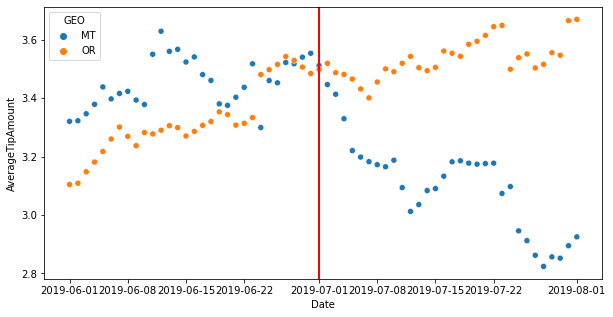

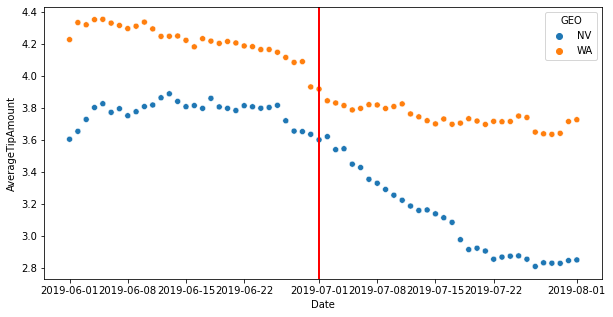

In [57]:
# ak_nv_tbl = gen_table('AverageTipAmount', 'AK', 'NV', date_range=['Jun 1 2019', 'Aug 1 2019'])
# ak_nv_ols = regression(ak_nv_tbl)
# plot_by_date(ak_nv_tbl, height=5, width=10)

# mt_nv_tbl = gen_table('AverageTipAmount', 'MT', 'NV', date_range=['Jun 1 2019', 'Aug 1 2019'])
# mt_nv_ols = regression(mt_nv_tbl)
# plot_by_date(mt_nv_tbl, height=5, width=10)

mt_or_tbl = gen_table('AverageTipAmount', 'MT', 'OR', date_range=['Jun 1 2019', 'Aug 1 2019'])
mt_or_ols = regression(mt_or_tbl)
plot_by_date(mt_or_tbl, height=5, width=10)

wa_nv_tbl = gen_table('AverageTipAmount', 'NV', 'WA', date_range=['Jun 1 2019', 'Aug 1 2019'])
wa_nv_ols = regression(wa_nv_tbl)
plot_by_date(wa_nv_tbl, height=5, width=10)

# wa_or_tbl = gen_table('AverageTipAmount', 'WA', 'OR', date_range=['Jun 1 2019', 'Aug 1 2019'])
# wa_or_ols = regression(wa_or_tbl)
# plot_by_date(wa_or_tbl, height=5, width=10)

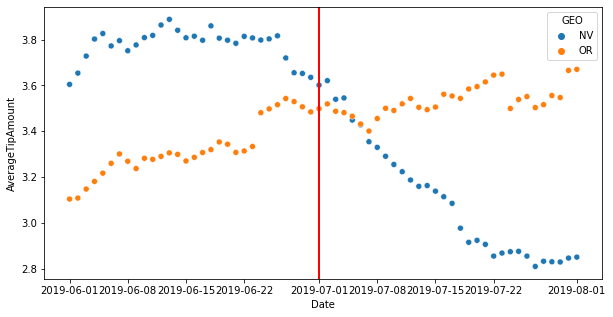

In [58]:
nv_or_tbl = gen_table('AverageTipAmount', 'NV', 'OR', date_range=['Jun 1 2019', 'Aug 1 2019'])
nv_or_ols = regression(nv_or_tbl)
plot_by_date(nv_or_tbl, height=5, width=10)

In [63]:
stargazer = Stargazer([nv_or_ols, mt_or_ols, wa_nv_ols])
stargazer.custom_columns(['Nevada_Oregon', 'Montana_Oregon', 'Washington_Nevada'], [1, 1, 1])
stargazer.covariate_order(['Intercept', 'Beta_1_State', 'Beta_2_Time', 'Beta_3_DiffDiff'])
stargazer.rename_covariates({'Intercept': 'Beta_0_Intercept'})
stargazer.show_model_numbers(False)
#stargazer.add_custom_notes(['SS-prefix indicates randomly sampled from the larger dataset as to make both the same size, DS-prefix indicates different size.',
#                            'O-suffix indicates identical (overlapping) recommendations (15%, 20%, 25%). A-suffix includes all recommendations from each dataset.',
#                           'F indicates that said regression includes $x_2$ (normalized fare price) in the regression.'])
stargazer.significance_levels([.05, .01, .001])
stargazer